# Predikcija magnitude zemljotresa





Rešavaće se problem predikcije opasnosti zemljotresa na osnovu podataka o prethodnim zemljotresima između 1995. i 2023. Godine na globalnom nivou. U pitanju je regresioni problem.

Prvo, učitamo biblioteke koje ćemo koristiti.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets, metrics,model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

Učitavamo bazu iz fajla earthquake_1995-2023.csv

*   Ako ne uspe učitavanje, skinuti bazu sa sledećeg linka: [ovde](https://www.kaggle.com/datasets/warcoder/earthquake-dataset/data)



# Izgled baze

In [ ]:
df = pd.read_csv('earthquake_1995-2023.csv')
print("Dimenzije: ",df.shape)

df.info()
df.head()

Dimenzije:  (1000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), o

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,location,continent,country
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,16-08-2023 12:47,7,4,green,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,"Sola, Vanuatu",NaN,Vanuatu
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,19-07-2023 00:22,8,6,yellow,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,"Intipucá, El Salvador",NaN,NaN
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,17-07-2023 03:05,7,5,green,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,"Loncopué, Argentina",South America,Argentina
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,16-07-2023 06:48,6,6,green,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,"Sand Point, Alaska",NaN,NaN
4,M 7.3 - Alaska Peninsula,7.3,16-07-2023 06:48,0,5,NaN,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,Alaska Peninsula,NaN,NaN


Iznad vidimo izgled zaglavlja baze i dimenzije.
U bazi ima 1000 uzoraka i 19 obeležja, gde jedan uzorak predstavlja jedan zemljotres sa svojim nazivom, karakteristikama i ostalim informacijama.

Obeležja nam redom predstavljaju:

•	Naziv koji je dat zemljotresu

•	Magnituda zemljotresa

•	Datum i vreme

•	Maksimalna prijavljena jačina u opsegu događaja

•	Maksimalna procenjena instrumentalna jačina događaja

•	Nivo upozorenja

•	Cunami: "1" za događaje u okeanskim regionima i "0" inače

•	Broj koji opisuje koliko je događaj značajan. Veći brojevi ukazuju na značajniji događaj. Ova vrednost se određuje na osnovu nekoliko faktora

•	Obeležje izvora informacija

•	Ukupan broj seizmičkih stanica koje su korišćene za određivanje lokacije zemljotresa.

•	Horizontalna udaljenost od epicentra do najbliže stanice

•	Najveći azimutalni razmak između azimutalno susednih stanica (u stepenima).
 Generalno, što je manji ovaj broj, to je pouzdanija izračunata horizontalna pozicija zemljotresa. Lokacije zemljotresa u kojima azimutalni jaz premašuje 180 stepeni obično imaju velike nesigurnosti u lokaciji i dubini.

•	Metod ili algoritam korišćen za izračunavanje magnituda za događaj

•	Dubina gde zemljotres počinje da se širi

•	Geografska širina / dužina, koordinatni sistem

•	Lokacija unutar zemlje

•	Kontinent zemlje koju je zemljotres pogodio

In [ ]:
i = 4

if i == 0:
  print((df['gap'].unique()))
elif i == 1:
  print((df['alert'].unique()))
elif i == 2:
  print((df['tsunami'].unique()))
elif i == 3:
  print((df['net'].unique()))
elif i == 4:
  print((df['magType'].unique()))
elif i == 5:
  print((df['location'].unique()))
elif i == 6:
  print((df['continent'].unique()))
else:
  print((df['country'].unique()))

print("Broj jedinstvenih vrednosti za obelezje kontinent: ", len(df['continent'].unique()))
print("Broj jedinstvenih vrednosti za obelezje lokacija: ", len(df['location'].unique()))
print("Broj jedinstvenih vrednosti za obelezje metode za izracunavanje magnitude: ", len(df['magType'].unique()))
print("Broj jedinstvenih vrednosti za obelezje izvora informacija: ", len(df['net'].unique()))
print("Broj jedinstvenih vrednosti za obelezje cunami: ", len(df['tsunami'].unique()))
print("Broj jedinstvenih vrednosti za obelezje nivo upozorenja: ", len(df['alert'].unique()))
print("Broj jedinstvenih vrednosti za obelezje naziv: ", len(df['title'].unique()))
print("Broj jedinstvenih vrednosti za obelezje drzava: ", len(df['country'].unique()))
print()

['mww' 'Mi' 'mwc' 'mwb' 'ml' 'mw' 'ms' 'mb' 'md']
Broj jedinstvenih vrednosti za obelezje kontinent:  7
Broj jedinstvenih vrednosti za obelezje lokacija:  503
Broj jedinstvenih vrednosti za obelezje metode za izracunavanje magnitude:  9
Broj jedinstvenih vrednosti za obelezje izvora informacija:  11
Broj jedinstvenih vrednosti za obelezje cunami:  2
Broj jedinstvenih vrednosti za obelezje nivo upozorenja:  5
Broj jedinstvenih vrednosti za obelezje naziv:  984
Broj jedinstvenih vrednosti za obelezje drzava:  57



# Predobrada

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      449 non-null    object 
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   object 
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
 16  location   994 non-null    object 
 17  continent  284 non-null    object 
 18  country    651 non-null    object 
dtypes: float64(6), int64(5), object(8)
memory usage: 

Numeričkih obeležja ima 10, a kategoričkih 8.

Najmanji broj kategorija ima obeležje *cunami* i to su:  “1” i “0” gde “1” znači da je bilo cunamija u okeanskoj regiji, a “0” da nije.

Najveci broj katergorija ima obeležje *naziv* i ima ih 984



In [ ]:
df.describe()

,magnitude,cdi,mmi,tsunami,sig,nst,dmin,gap,depth,latitude,longitude
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.940150,3.605000,6.02700,0.325000,847.915000,193.918000,1.125174,20.926290,74.612541,4.315554,51.486576
std,0.438148,3.328972,1.43399,0.468609,301.802632,239.045858,2.073164,24.415895,130.812590,26.633320,117.478302
min,6.500000,0.000000,1.00000,0.000000,650.000000,0.000000,0.000000,0.000000,2.700000,-61.848400,-179.968000
25%,6.600000,0.000000,5.00000,0.000000,691.000000,0.000000,0.000000,0.000000,16.000000,-13.518500,-71.694450
50%,6.800000,4.000000,6.00000,0.000000,744.000000,0.000000,0.000000,18.000000,29.000000,-2.443500,107.791000
75%,7.100000,7.000000,7.00000,1.000000,874.250000,403.000000,1.549250,27.000000,55.000000,25.167250,148.364750
max,9.100000,9.000000,10.00000,1.000000,2910.000000,934.000000,17.654000,239.000000,670.810000,71.631200,179.662000


In [ ]:
#Pretvaranje kolone date_time u tri nove kolone: day, month i year
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

df['day'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year

df.drop(['date_time'], inplace = True, axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   cdi        1000 non-null   int64  
 3   mmi        1000 non-null   int64  
 4   alert      449 non-null    object 
 5   tsunami    1000 non-null   int64  
 6   sig        1000 non-null   int64  
 7   net        1000 non-null   object 
 8   nst        1000 non-null   int64  
 9   dmin       1000 non-null   float64
 10  gap        1000 non-null   float64
 11  magType    1000 non-null   object 
 12  depth      1000 non-null   float64
 13  latitude   1000 non-null   float64
 14  longitude  1000 non-null   float64
 15  location   994 non-null    object 
 16  continent  284 non-null    object 
 17  country    651 non-null    object 
 18  day        1000 non-null   int64  
 19  month      1000 non-null   int64  
 20  year     

Pošto rešavamo problem linearne regresije, neophodno je da znamo opseg, srednju vrednost i medijanu obeležja koje ćemo predviđati. Ove vrednosti čitamo iz tabele iznad.



Magnituda:

> Opseg: **6.5 - 9.1**

> Sr.vr:  **6.94**

> Medijana: **6.8**



In [ ]:
NANs = df.isnull().sum()
print("Broj nedostajućih vrednosti po obeležjima:\n", NANs)
print("Udeo nedostajućih vrednosti za obeležje alert: ", df['alert'].isnull().sum()/len(df)*100, "%")
print("Udeo nedostajućih vrednosti za obeležje location: ", df['location'].isnull().sum()/len(df)*100, "%")
print("Udeo nedostajućih vrednosti za obeležje continent: ", df['continent'].isnull().sum()/len(df)*100, "%")
print("Udeo nedostajućih vrednosti za obeležje country: ", df['country'].isnull().sum()/len(df)*100, "%")

Broj nedostajućih vrednosti po obeležjima:
 title          0
magnitude      0
cdi            0
mmi            0
alert        551
tsunami        0
sig            0
net            0
nst            0
dmin           0
gap            0
magType        0
depth          0
latitude       0
longitude      0
location       6
continent    716
country      349
day            0
month          0
year           0
dtype: int64
Udeo nedostajućih vrednosti za obeležje alert:  55.1 %
Udeo nedostajućih vrednosti za obeležje location:  0.6 %
Udeo nedostajućih vrednosti za obeležje continent:  71.6 %
Udeo nedostajućih vrednosti za obeležje country:  34.9 %


U bazi nema nevalidnih podataka, ali ima nedostajućih vrednosti,  *alert* (55.1%),  *location* (0.6%), *continent* (71.6%), *country* (34.9%)

Alert ima veliki broj nedostajucih vrednosti i možemo ga izbaciti kako ne možemo dodeliti nedostajuće vrednosti obeležjima.

Isto tako, kako imamo sve geografske dužine i širine, lokacije gde se desio zemljotres su jednistveno određene i zbog toga nam nisu potrebni lokacija, kontinent i države.

In [ ]:
#dropovanje kolona sa nedostajucim vrednostima
df.drop(['continent', 'country', 'location', 'alert'], inplace = True, axis=1)

In [ ]:
df.head()

,title,magnitude,cdi,mmi,tsunami,sig,net,nst,dmin,gap,magType,depth,latitude,longitude,day,month,year
0,"M 6.5 - 42 km W of Sola, Vanuatu",6.5,7,4,0,657,us,114,7.177000,25.0,mww,192.955,-13.8814,167.1580,16,8,2023
1,"M 6.5 - 43 km S of Intipucá, El Salvador",6.5,8,6,0,775,us,92,0.679000,40.0,mww,69.727,12.8140,-88.1265,19,7,2023
2,"M 6.6 - 25 km ESE of Loncopué, Argentina",6.6,7,5,0,899,us,70,1.634000,28.0,mww,171.371,-38.1911,-70.3731,17,7,2023
3,"M 7.2 - 98 km S of Sand Point, Alaska",7.2,6,6,1,860,us,173,0.907000,36.0,mww,32.571,54.3844,-160.6990,16,7,2023
4,M 7.3 - Alaska Peninsula,7.3,0,5,1,820,at,79,0.879451,172.8,Mi,21.000,54.4900,-160.7960,16,7,2023


#Autlajeri:
U odnosu godine i magnitude u svakoj godini su zemljotresi bili između 6.25 i 7.30 i u svakoj
godini ima prosečno 1.9 uzoraka gde je magnituda bila značajno veća.
U odnosu dubine i magnitude su zemljotresi bili između 0 i 100 jedinica dubine i ima puno
autlajera koji idu i do 700 jedinica dubine

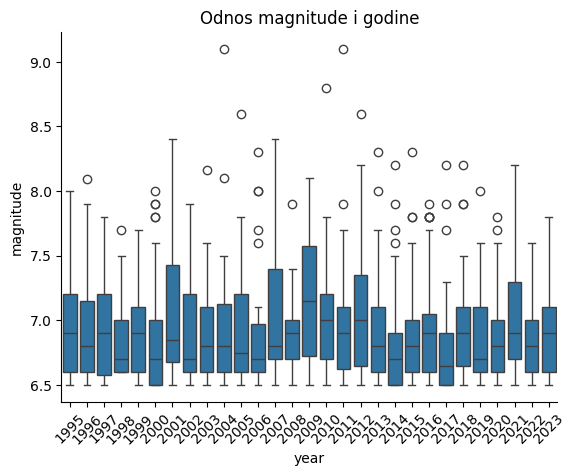

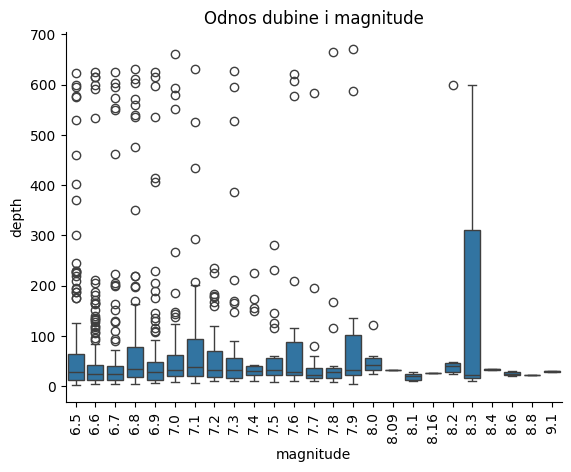

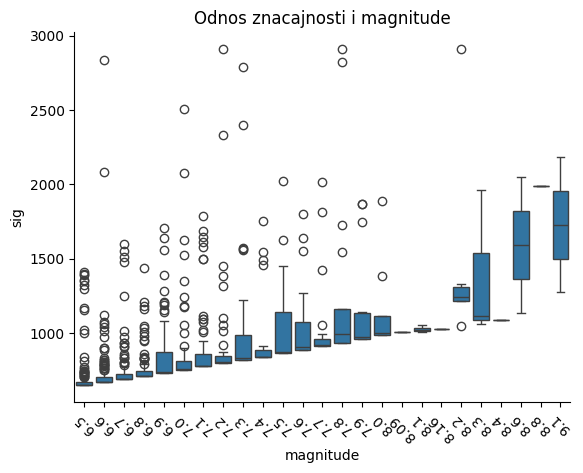

In [ ]:
sb.boxplot(x="year", y="magnitude", data=df)
plt.title("Odnos magnitude i godine")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(rotation=45)
plt.show()

sb.boxplot(x="magnitude", y="depth", data=df)
plt.title("Odnos dubine i magnitude")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(rotation=90)
plt.show()

sb.boxplot(x='magnitude', y="sig", data=df)
plt.title("Odnos znacajnosti i magnitude")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(rotation=135)
plt.show()

Kolinearnost između numeričkih obležja:

<ipython-input-514-55ebbf4b8058>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(),annot=True)


<Axes: >

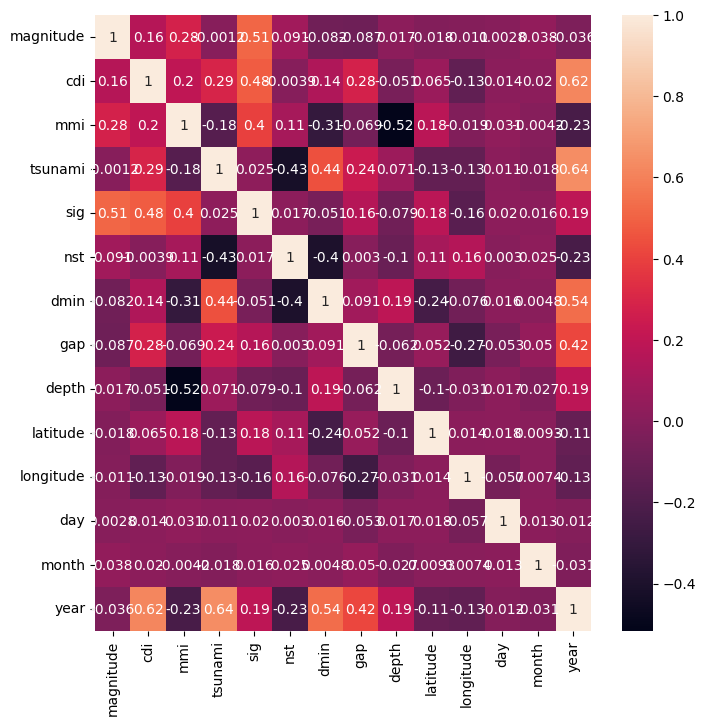

In [ ]:
plt.figure(figsize=(8,8))
sb.heatmap(df.corr(),annot=True)

Odstupanje raspodele varijabli magnitude od normalne raspodele dobijene korišćenjem uzoračke sr.vr. i standardne devijacije (asimetričnost I spljoštenost)

Uzorak srednje vrednosti: 6.940150000000001
Uzorak standardne devijacije: 0.43792884981467023
Asimetrija: 1.37
Spljoštenost: 1.88


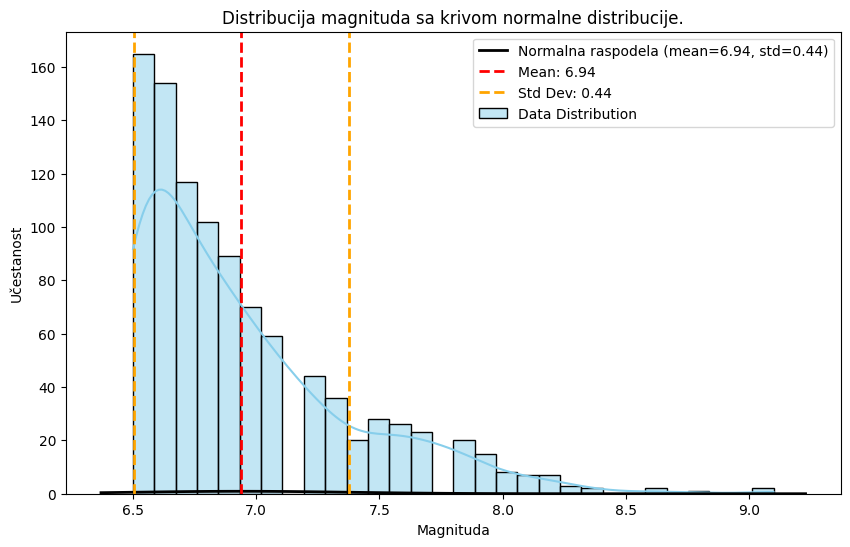

In [ ]:
mean_value = np.mean(df['magnitude'])
std_dev = np.std(df['magnitude'])
skewness = skew(df['magnitude'])
kurt = kurtosis(df['magnitude'])

print(f"Uzorak srednje vrednosti: {mean_value}")
print(f"Uzorak standardne devijacije: {std_dev}")
print(f"Asimetrija: {skewness.round(2)}")
print(f"Spljoštenost: {kurt.round(2)}")

plt.figure(figsize=(10, 6))
sb.histplot(df['magnitude'], bins=30, kde=True, color='skyblue', label='Data Distribution')

#Crtanje krive normalne raspodele sa istom srednjom vrednošću kao podaci.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_value, std_dev)
plt.plot(x, p, 'k', linewidth=2, label=f'Normalna raspodela (mean={mean_value:.2f}, std={std_dev:.2f})')

plt.title('Distribucija magnituda sa krivom normalne distribucije.')
plt.xlabel('Magnituda')
plt.ylabel('Učestanost')
plt.legend()

#Prikaz sr. vrednosti, std, skewness, i kurtosis na grafu
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + std_dev, color='orange', linestyle='dashed', linewidth=2, label=f'Std Dev: {std_dev:.2f}')
plt.axvline(mean_value - std_dev, color='orange', linestyle='dashed', linewidth=2)
plt.legend()

plt.show()

# Priprema podataka za obuku modela


Promenljiva x predstavlja skup obeležja koji se koriste za predikciju ciljne promenljive, dok promenljiva y predstavlja ciljnu promenljivu koju želimo da predvidimo.

In [ ]:
x = df.drop(["magnitude","title","net","magType"], axis=1)
y = df["magnitude"]

y_std = (y-np.mean(y))/np.std(y)
print(y_std.describe())

count    1.000000e+03
mean    -2.195577e-15
std      1.000500e+00
min     -1.005072e+00
25%     -7.767243e-01
50%     -3.200292e-01
75%      3.650136e-01
max      4.931966e+00
Name: magnitude, dtype: float64


In [ ]:
# definisanje modela za evaluaciju
def model_evaluation(y_test, y_predicted, N, d):
    mse = np.mean((y_test-y_predicted)**2)
    mae = np.mean(np.abs(y_test-y_predicted))
    rmse = np.sqrt(mse)
    r2 = 1-np.sum((y_test-y_predicted)**2)/np.sum((y_test-np.mean(y_test))**2)
    r2_adj = 1-((1-r2)*(N-1))/(N-d-1)

    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    res=pd.concat([pd.DataFrame(y_test.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse,mae,rmse,r2,r2_adj

In [ ]:
numeric_feats = [item for item in x.columns if '_' not in item]
print(numeric_feats)
dummy_feats = [item for item in x.columns if '_' in item]
print(dummy_feats)

['cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'day', 'month', 'year']
[]


#Linearna regresija i standardizacija

In [ ]:
#standardizacija obelezja normalna distribucija sa srednjom vrednošću 0 i standardnom devijacijom
def standardizacija(x_train, x_test, numeric_feats, dummy_feats):
  cols = x_train.columns
  s = StandardScaler()
  s.fit(x_train[numeric_feats])
  x_train_std = s.transform(x_train[numeric_feats])
  x_test_std = s.transform(x_test[numeric_feats])
  x_train_std = pd.DataFrame(x_train_std)
  x_test_std = pd.DataFrame(x_test_std)

  x_train_std = pd.concat([x_train_std, x_train[dummy_feats].reset_index(drop=True)], axis=1)
  x_test_std = pd.concat([x_test_std, x_test[dummy_feats].reset_index(drop=True)], axis=1)

  x_train_std.columns = list(cols)
  x_test_std.columns = list(cols)
  return x_train_std, x_test_std

#Podela podataka na trening i test skupove (10% test, 90% trening):
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#Prazne liste za evaluaciju modela
mse=[]; mae=[]; rmse=[]; r2=[]; r2_adj=[]

#Unakrsna validacija sa 10 podskupova, pri čemu se podaci nasumično mešaju pre podele
kf = KFold(n_splits=10, shuffle=True)
indexes = kf.split(x_train, y_train)

#Iteracija kroz podskupove unakrsne validacije:
for train_index, test_index in indexes:
  x_train_i = x_train.iloc[train_index,:]
  x_test_i = x_train.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

  x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i, numeric_feats, dummy_feats)
  regressor = LinearRegression(fit_intercept=True) #hiperparametri
  regressor.fit(x_train_std_i, y_train_i)
  y_pred = regressor.predict(x_test_std_i)
  mse_i,mae_i,rmse_i,r2_i,r2_adj_i = model_evaluation(y_test_i, y_pred, x_train_std_i.shape[0], x_train_std_i.shape[1])
  mse.append(mse_i); mae.append(mae_i); rmse.append(rmse_i); r2.append(r2_i); r2_adj.append(r2_adj_i)

print("prosecne mere uspesnosti iz unakrsne validacije su: ")
print("mse: ", np.mean(mse))
print("mae: ", np.mean(mae))
print("rmse: ", np.mean(rmse))
print("r2: ", np.mean(r2))
print("r2_adj: ", np.mean(r2_adj))

Mean squared error:  0.13125897366733935
Mean absolute error:  0.26017496344629404
Root mean squared error:  0.36229680328059666
R2 score:  -0.06430456345143853
R2 adjusted score:  -0.08168642189976594
      y    y_pred
0   6.5  6.843203
1   7.6  7.338779
2   7.0  7.685106
3   6.6  6.832654
4   6.9  6.856177
5   7.5  7.063541
6   6.5  6.852368
7   6.8  6.915410
8   6.6  6.756620
9   6.8  6.909181
10  7.0  7.087962
11  7.2  7.113351
12  7.0  6.957104
13  6.8  6.843436
14  7.8  8.584250
15  6.8  6.818478
16  7.1  6.894829
17  6.9  6.896586
18  6.6  6.816818
19  6.7  6.882950
Mean squared error:  0.11597834619227447
Mean absolute error:  0.26342333210884455
Root mean squared error:  0.34055593695056097
R2 score:  0.3213034590239401
R2 adjusted score:  0.3102192190331251
      y    y_pred
0   6.6  6.723835
1   6.6  6.963207
2   7.1  6.985398
3   6.8  6.574192
4   7.2  6.869190
5   6.7  7.311640
6   8.4  7.370186
7   7.0  6.988436
8   7.3  6.998552
9   6.6  7.137188
10  6.8  6.750330
11  6.

Traženje najboljih hiperparametara za Ridge regresiju

In [ ]:
#Podela podataka na trening, test skup i validacioni skup
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.1, random_state=42)
x_train_std, x_val_std = standardizacija(x_train, x_val, numeric_feats, dummy_feats)

In [ ]:
#Definisanje modela Ridge regresije
ridge_model = Ridge()

#Postavljanje vrednosti alpha koje cemo ispitati
param_grid = {'alpha': [1,3,5,7,10]}

#GridSearchCV za traženje najbolje vrednosti alpha
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='r2', cv=10)
grid_search.fit(x_train_std, y_train)

#Najbolja vrednost za alpha
best_alpha = grid_search.best_params_['alpha']

#Prikaz rezultata
print(f"Best value for alpha: {best_alpha}")

#Evaluacija modela na test skupu
y_pred = grid_search.predict(x_val_std)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean squared error: {mse}")

Best value for alpha: 10
Mean squared error: 0.1586055657365169


Ispis i iscrtavanje najboljih hiperparametara za ridge regresiju

Mean squared error:  0.1586055657365169
Mean absolute error:  0.3005600826047096
Root mean squared error:  0.3982531427829753
R2 score:  0.38295284045141564
R2 adjusted score:  0.3728754370919538
      y    y_pred
0   7.3  7.010483
1   8.1  6.902920
2   6.8  6.970868
3   6.5  6.780513
4   6.8  6.591105
5   7.4  7.065586
6   6.9  6.937817
7   6.5  6.520474
8   7.4  6.914939
9   6.8  6.812777
10  6.9  6.788218
11  6.8  6.961154
12  7.1  7.418858
13  6.8  6.871233
14  7.5  7.177724
15  7.4  6.891373
16  6.5  6.841140
17  6.5  6.774356
18  7.8  7.174931
19  6.7  6.888542
koeficijenti:  [-0.0070873   0.06369808  0.08050821  0.2310689   0.05422079  0.00779275
 -0.03597969  0.06066586 -0.04440222  0.02014924 -0.0094821   0.01069163
 -0.08651394]


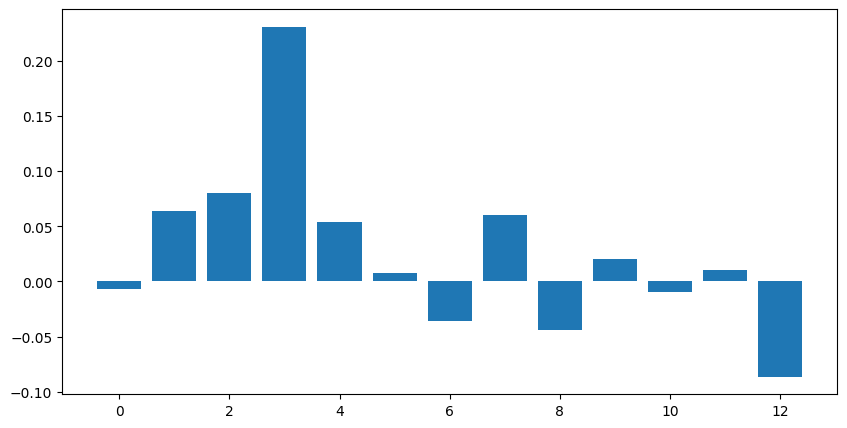

In [ ]:
#Podela podataka na trening i test skup
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size=0.1, random_state=42)
x_train_std, x_val_std = standardizacija(x_train, x_val, numeric_feats, dummy_feats)

#Inicijalizacija modela
ridge_model = Ridge(alpha=10)

#Obuka modela
ridge_model.fit(x_train_std, y_train)

#Testiranje modela
y_predicted = ridge_model.predict(x_val_std)

#Evaluacija (racunanje mera uspesnosti)
model_evaluation(y_val, y_predicted, x_train_std.shape[0], x_train_std.shape[1])

#Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
print("koeficijenti: ", ridge_model.coef_)

#x.head()

Traženje najboljih hiperparametara za lasso regresiju

In [ ]:
#Definisanje modela Laso regresije
lasso_model = Lasso()

#Postavljanje vrednosti alpha koje cemo ispitati
param_grid = {'alpha': [0.001,0.01, 0.05,0.1,0.3,0.5,0.7,0.8,1]}

#GridSearchCV za traženje najbolje vrednosti alpha
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, scoring='r2', cv=10)
grid_search.fit(x_train_std, y_train)

#Najbolja vrednost za alpha
best_alpha = grid_search.best_params_['alpha']

#Prikaz rezultata
print(f"Najbolja vrednost za alpha: {best_alpha}")

#Evaluacija modela na test skupu
y_pred = grid_search.predict(x_val_std)
mse = mean_squared_error(y_val, y_pred)
print(f"Srednje kvadratna greška na test skupu: {mse}")

Najbolja vrednost za alpha: 0.001
Srednje kvadratna greška na test skupu: 0.15833249280726006


Ispis i iscrtavanje najboljih hiperparametara za lasso regresiju

Mean squared error:  0.15833249280726006
Mean absolute error:  0.3001343805947394
Root mean squared error:  0.3979101567028166
R2 score:  0.3840152172637621
R2 adjusted score:  0.37395516427937625
      y    y_pred
0   7.3  7.012789
1   8.1  6.895780
2   6.8  6.971554
3   6.5  6.781512
4   6.8  6.589390
5   7.4  7.064430
6   6.9  6.940112
7   6.5  6.527250
8   7.4  6.912884
9   6.8  6.814353
10  6.9  6.789657
11  6.8  6.958204
12  7.1  7.426599
13  6.8  6.869829
14  7.5  7.180028
15  7.4  6.890865
16  6.5  6.840453
17  6.5  6.776002
18  7.8  7.173165
19  6.7  6.890312
koeficijenti:  [-0.00587257  0.06129072  0.0807263   0.23341965  0.05325669  0.00659099
 -0.03542589  0.05981596 -0.04445535  0.01994852 -0.00862159  0.00969387
 -0.08815659]


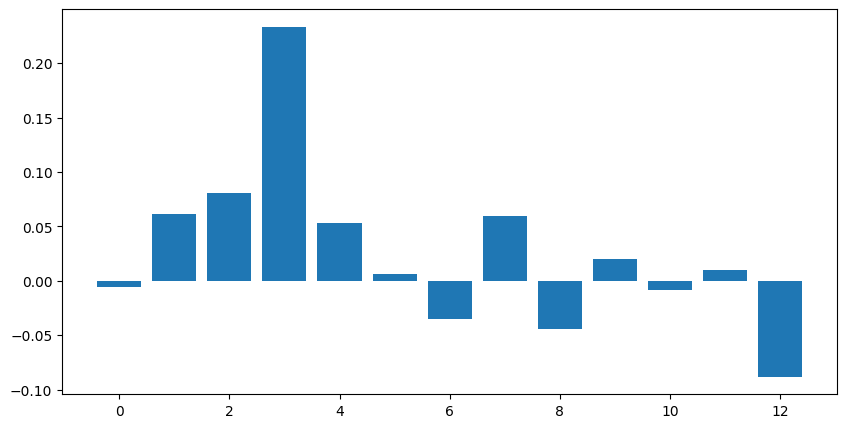

In [ ]:
# Inicijalizacija modela
lasso_model = Lasso(alpha=0.001)

#Obuka modela
lasso_model.fit(x_train_std, y_train)

# Testiranje modela
y_pred = lasso_model.predict(x_val_std)

# Evaluacija (racunanje mera uspesnosti)
model_evaluation(y_val, y_pred, x_train_std.shape[0], x_train_std.shape[1])

# Ilustracija koeficijenata
plt.figure(figsize=(10,5))
plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
print("koeficijenti: ", lasso_model.coef_)

#kNN -	K-najbližih suseda


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

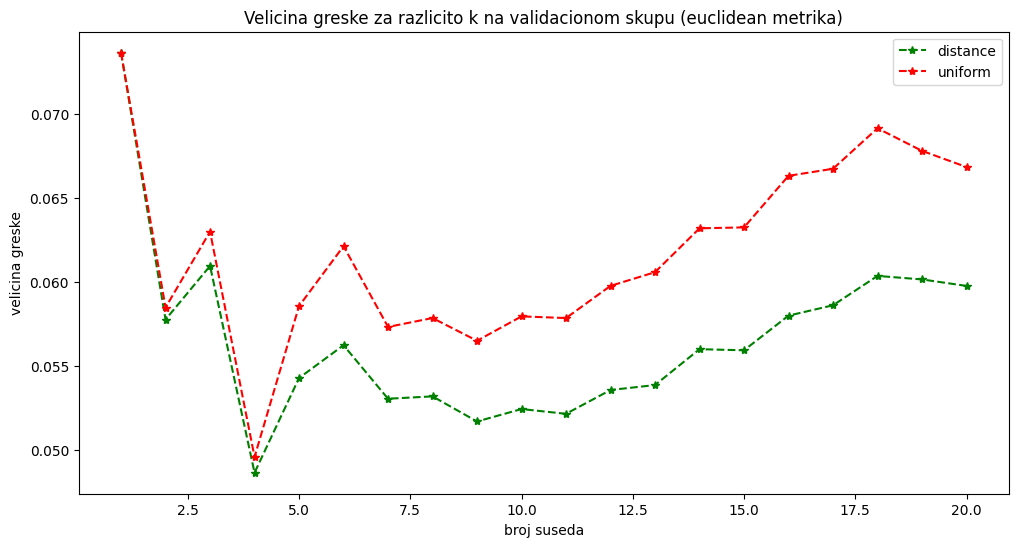

In [ ]:
lista1 = []
lista2 = []
# Racunanje greske za razlicito k i za razlicite tezine, euclidean metrika
for i in range(1, 21):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='euclidean', weights = 'distance')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista1.append(metrics.mean_squared_error(y_val, y_pred))
for i in range(1, 21):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='euclidean', weights = 'uniform')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista2.append(metrics.mean_squared_error(y_val, y_pred))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), lista1, color='green', linestyle='dashed', marker='*',label='distance')
plt.plot(range(1, 21), lista2, color='red', linestyle='dashed', marker='*', label='uniform')
plt.title('Velicina greske za razlicito k na validacionom skupu (euclidean metrika)')
plt.xlabel('broj suseda')
plt.ylabel('velicina greske')
plt.legend()

Text(0, 0.5, 'velicina greske')

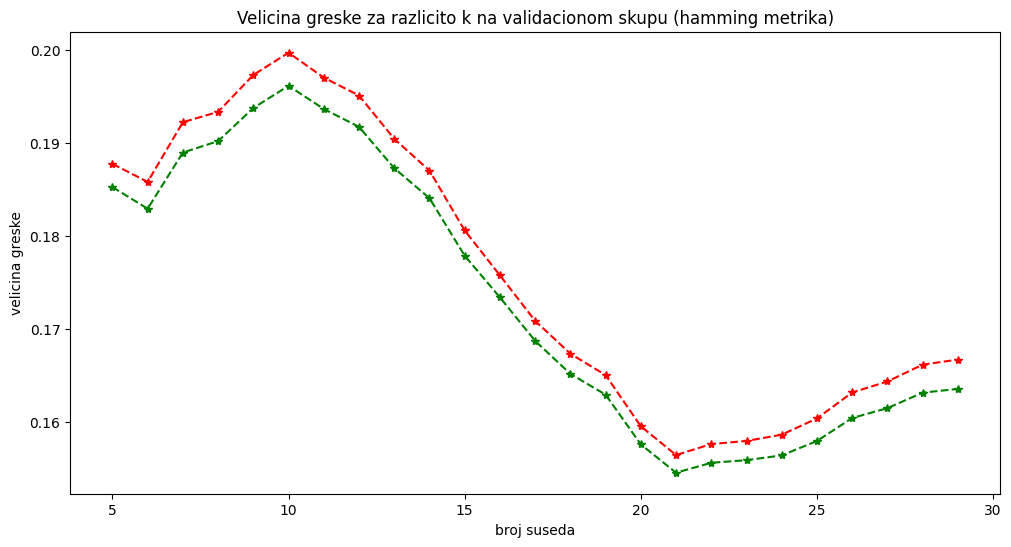

In [ ]:
lista1 = []
lista2 = []
# Racunanje greske za razlicito k i za razlicite tezine, hamming metrika
for i in range(5, 30):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='hamming', weights = 'distance')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista1.append(metrics.mean_squared_error(y_val, y_pred))
for i in range(5, 30):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='hamming', weights = 'uniform')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista2.append(metrics.mean_squared_error(y_val, y_pred))
plt.figure(figsize=(12, 6))
plt.plot(range(5, 30), lista1, color='green', linestyle='dashed', marker='*')
plt.plot(range(5, 30), lista2, color='red', linestyle='dashed', marker='*')
plt.title('Velicina greske za razlicito k na validacionom skupu (hamming metrika)')
plt.xlabel('broj suseda')
plt.ylabel('velicina greske')

Text(0, 0.5, 'velicina greske')

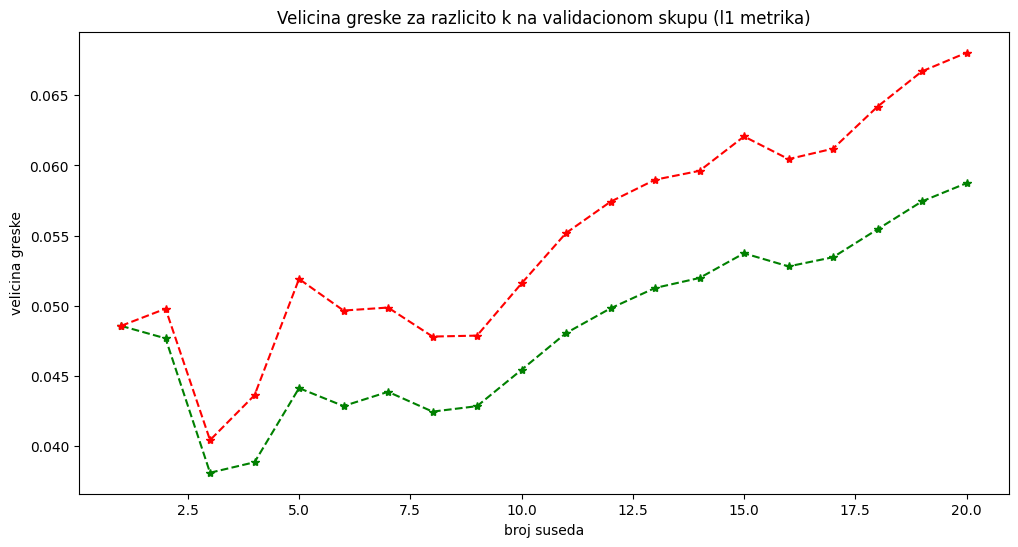

In [ ]:
lista1 = []
lista2 = []
# Racunanje greske za razlicito k i za razlicite tezine, l1 metrika
for i in range(1, 21):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='l1', weights = 'distance')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista1.append(metrics.mean_squared_error(y_val, y_pred))
for i in range(1, 21):
    regresor = KNeighborsRegressor(n_neighbors=i, metric='l1', weights = 'uniform')
    regresor.fit(x_train, y_train)
    y_pred = regresor.predict(x_val)
    lista2.append(metrics.mean_squared_error(y_val, y_pred))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), lista1, color='green', linestyle='dashed', marker='*')
plt.plot(range(1, 21), lista2, color='red', linestyle='dashed', marker='*')
plt.title('Velicina greske za razlicito k na validacionom skupu (l1 metrika)')
plt.xlabel('broj suseda')
plt.ylabel('velicina greske')

Prikaz najboljih rešenja dobijenih iz grafika iznad


In [ ]:
#L2 ili Euclidean metrika:
regresor_e = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights = 'uniform')
#L1 ili Manhattan metrika:
regresor_l = KNeighborsRegressor(n_neighbors=8, metric='l1', weights = 'distance')
regresor_h = KNeighborsRegressor(n_neighbors=21, metric='hamming', weights = 'distance')

regresor_e.fit(x_train, y_train)
regresor_l.fit(x_train, y_train)
regresor_h.fit(x_train, y_train)

#validacija
y_pred_e= regresor_e.predict(x_val)
mse_e = mean_squared_error(y_val, y_pred_e)
print("Mean Squared Error za euklcidiana:", mse_e)

y_pred_l = regresor_l.predict(x_val)
mse_l = mean_squared_error(y_val, y_pred_l)
print("Mean Squared Error za l1 normu:", mse_l)

y_pred_h = regresor_h.predict(x_val)
mse_h = mean_squared_error(y_val, y_pred_h)
print("Mean Squared Error za hamminga:", mse_h)

Mean Squared Error za euklcidiana: 0.05855999999999999
Mean Squared Error za l1 normu: 0.0424400802166696
Mean Squared Error za hamminga: 0.15456452469480308


#SVM - support vector machine

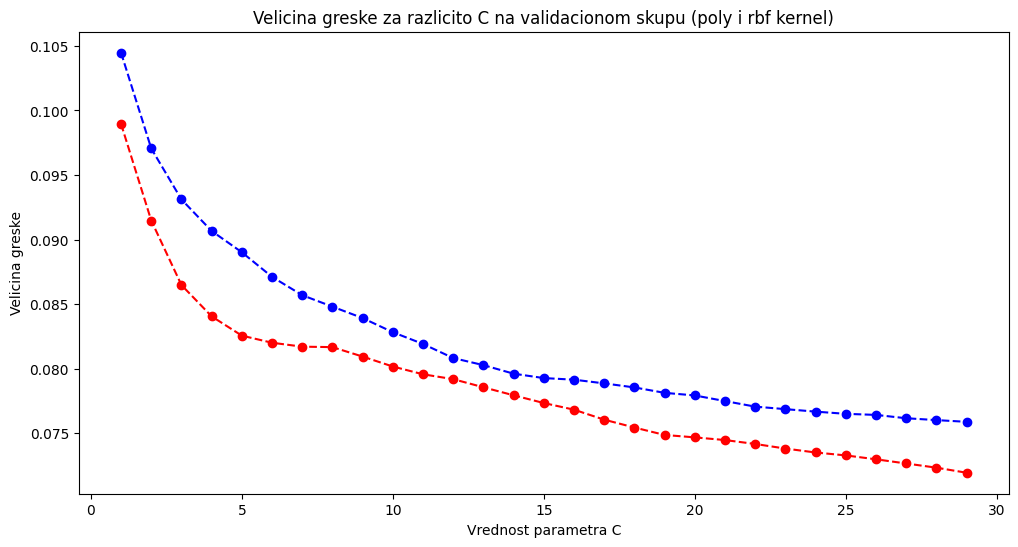

In [ ]:
# Inicijalizacija prazne liste za greške
errors_p = []
errors_r = []

# Računanje greške za različite vrednosti parametra C
for c_value in range(1, 30):
    # Inicijalizacija SVM regresora sa linearnom kernel funkcijom
    svr_regressor = SVR(kernel='poly', C=c_value)
    # Obuka SVM regresora na trening podacima
    svr_regressor.fit(x_train, y_train)
    # Predikcija na validacionom skupu
    y_pred = svr_regressor.predict(x_val)
    # Računanje srednje kvadratne greške
    mse = mean_squared_error(y_val, y_pred)
    # Dodavanje greške u listu grešaka
    errors_p.append(mse)
for c_value in range(1, 30):
    # Inicijalizacija SVM regresora sa linearnom kernel funkcijom
    svr_regressor = SVR(kernel='rbf', C=c_value)
    # Obuka SVM regresora na trening podacima
    svr_regressor.fit(x_train, y_train)
    # Predikcija na validacionom skupu
    y_pred = svr_regressor.predict(x_val)
    # Računanje srednje kvadratne greške
    mse = mean_squared_error(y_val, y_pred)
    # Dodavanje greške u listu grešaka
    errors_r.append(mse)

# Plotovanje rezultata
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), errors_p, color='blue', linestyle='dashed', marker='o')
plt.plot(range(1, 30), errors_r, color='red', linestyle='dashed', marker='o')

plt.title('Velicina greske za razlicito C na validacionom skupu (poly i rbf kernel)')
plt.xlabel('Vrednost parametra C')
plt.ylabel('Velicina greske')
plt.show()

In [ ]:
'''#kod se ne izvrsava ispod 10 min
errors_l = []
for c_value in range(1, 20):
    # Inicijalizacija SVM regresora sa linearnom kernel funkcijom
    svr_regressor = SVR(kernel='linear', C=c_value)
    # Obuka SVM regresora na trening podacima
    svr_regressor.fit(x_train, y_train)
    # Predikcija na validacionom skupu
    y_pred = svr_regressor.predict(x_val)
    # Računanje srednje kvadratne greške
    mse = mean_squared_error(y_val, y_pred)
    # Dodavanje greške u listu grešaka
    errors_l.append(mse)
plt.plot(range(1, 20), errors_l, color='purple', linestyle='dashed', marker='o')
'''

"#kod se ne izvrsava ispod 10 min\nerrors_l = []\nfor c_value in range(1, 20):\n    # Inicijalizacija SVM regresora sa linearnom kernel funkcijom\n    svr_regressor = SVR(kernel='linear', C=c_value)\n    # Obuka SVM regresora na trening podacima\n    svr_regressor.fit(x_train, y_train)\n    # Predikcija na validacionom skupu\n    y_pred = svr_regressor.predict(x_val)\n    # Računanje srednje kvadratne greške\n    mse = mean_squared_error(y_val, y_pred)\n    # Dodavanje greške u listu grešaka\n    errors_l.append(mse)\nplt.plot(range(1, 20), errors_l, color='purple', linestyle='dashed', marker='o')\n"

In [ ]:
# Inicijalizacija SVM regresora
svr_regressor_l = SVR(kernel='linear', C=2)
svr_regressor_p = SVR(kernel='poly', C=27)
svr_regressor_r = SVR(kernel='rbf', C=29)

# Obuka SVM regresora na trening podacima
svr_regressor_l.fit(x_train, y_train)
svr_regressor_p.fit(x_train, y_train)
svr_regressor_r.fit(x_train, y_train)

# Predikcija na validacionom skupu
y_pred_l = svr_regressor_l.predict(x_val)
y_pred_p = svr_regressor_p.predict(x_val)
y_pred_r = svr_regressor_r.predict(x_val)

# Računanje srednje kvadratne greške
mse_l = mean_squared_error(y_val, y_pred_l)
mse_p = mean_squared_error(y_val, y_pred_p)
mse_r = mean_squared_error(y_val, y_pred_r)

print("Srednja kvadratna greška (MSE) za SVM:", mse_l)
print("Srednja kvadratna greška (MSE) za SVM:", mse_p)
print("Srednja kvadratna greška (MSE) za SVM:", mse_r)

Srednja kvadratna greška (MSE) za SVM: 2.810284227382946
Srednja kvadratna greška (MSE) za SVM: 0.07616764838937493
Srednja kvadratna greška (MSE) za SVM: 0.0719480562318098


#PCA - Principal Component Analysis

Primena PCA za linearnu regresiju

0.31259369875082005


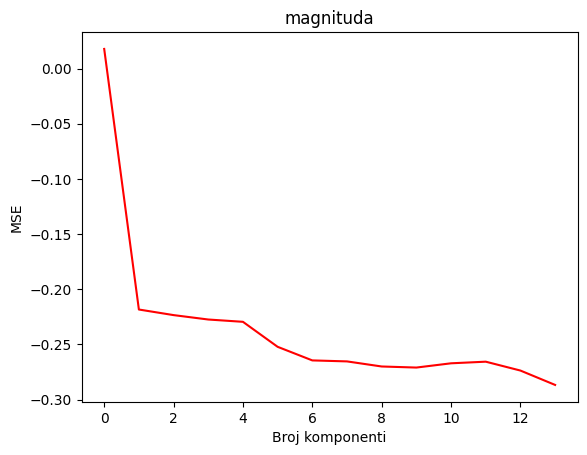

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(x_train)

#definisemo unakrsnu validaciju sa 10 podskupova
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
regr = LinearRegression()
mse = []

#Racunamo mse za jedan podskup
score = -1*model_selection.cross_val_score(regr, np.ones((len(x_reduced),1)), y_train, cv=cv, scoring='r2').mean()
mse.append(score)

#racunamo mse za svaki podskup
for i in np.arange(1, 14):
  score = -1*model_selection.cross_val_score(regr, x_reduced[:,:i], y_train, cv=cv, scoring='r2').mean()
  mse.append(score)

plt.plot(mse,color='red')
plt.xlabel('Broj komponenti')
plt.ylabel('MSE')
plt.title('magnituda')

#scale trening i test podataka
x_reduced_train = pca.fit_transform(x_train)
x_reduced_test = pca.transform(x_test)[:,:1]

#trening pca podataka na osnovu testa
regr.fit(x_reduced_train[:,:1], y_train)

#racunaje MSE
y_pred = regr.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Primena PCA za KNN

0.28832620415078464


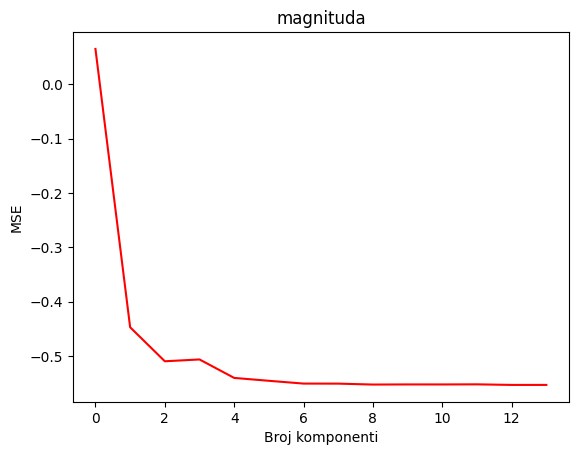

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(x_train)

#definisemo unakrsnu validaciju sa 10 podskupova
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights = 'uniform')
mse = []

#Racunamo mse za jedan podskup
score = -1*model_selection.cross_val_score(regr, np.ones((len(x_reduced),1)), y_train, cv=cv, scoring='r2').mean()
mse.append(score)

#racunamo mse za svaki podskup
for i in np.arange(1, 14):
  score = -1*model_selection.cross_val_score(regr, x_reduced[:,:i], y_train, cv=cv, scoring='r2').mean()
  mse.append(score)

plt.plot(mse,color='red')
plt.xlabel('Broj komponenti')
plt.ylabel('MSE')
plt.title('magnituda')

#scale trening i test podataka
x_reduced_train = pca.fit_transform(x_train)
x_reduced_test = pca.transform(x_test)[:,:1]

#trening pca podataka na osnovu testa
regr.fit(x_reduced_train[:,:1], y_train)

#racunaje MSE
y_pred = regr.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Primena PCA za ridge regresiju

0.3125937049450649


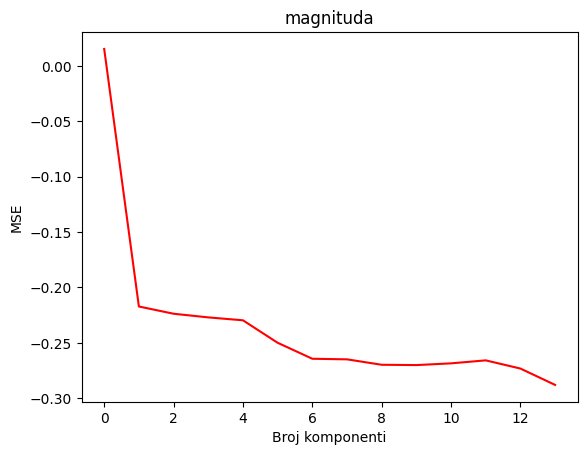

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(x_train)

#definisemo unakrsnu validaciju sa 10 podskupova
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = Ridge(alpha=10)
mse = []

#Racunamo mse za jedan podskup
score = -1*model_selection.cross_val_score(regr, np.ones((len(x_reduced),1)), y_train, cv=cv, scoring='r2').mean()
mse.append(score)

#racunamo mse za svaki podskup
for i in np.arange(1, 14):
  score = -1*model_selection.cross_val_score(regr, x_reduced[:,:i], y_train, cv=cv, scoring='r2').mean()
  mse.append(score)

plt.plot(mse,color='red')
plt.xlabel('Broj komponenti')
plt.ylabel('MSE')
plt.title('magnituda')

#scale trening i test podataka
x_reduced_train = pca.fit_transform(x_train)
x_reduced_test = pca.transform(x_test)[:,:1]

#trening pca podataka na osnovu testa
regr.fit(x_reduced_train[:,:1], y_train)

#racunaje MSE
y_pred = regr.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

Primena PCA za Lasso regresiju

0.3125944237741109


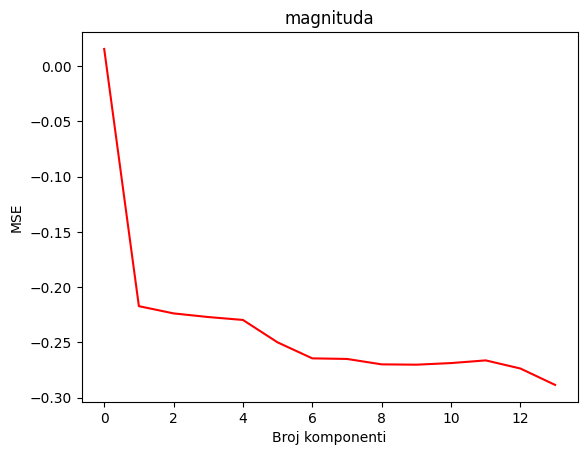

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(x_train)

#definisemo unakrsnu validaciju sa 10 podskupova
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = Lasso(alpha=0.001)
mse = []

#Racunamo mse za jedan podskup
score = -1*model_selection.cross_val_score(regr, np.ones((len(x_reduced),1)), y_train, cv=cv, scoring='r2').mean()
mse.append(score)

#racunamo mse za svaki podskup
for i in np.arange(1, 14):
  score = -1*model_selection.cross_val_score(regr, x_reduced[:,:i], y_train, cv=cv, scoring='r2').mean()
  mse.append(score)

plt.plot(mse,color='red')
plt.xlabel('Broj komponenti')
plt.ylabel('MSE')
plt.title('magnituda')

#scale trening i test podataka
x_reduced_train = pca.fit_transform(x_train)
x_reduced_test = pca.transform(x_test)[:,:1]

#trening pca podataka na osnovu testa
regr.fit(x_reduced_train[:,:1], y_train)

#racunaje MSE
y_pred = regr.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.38779381331684454


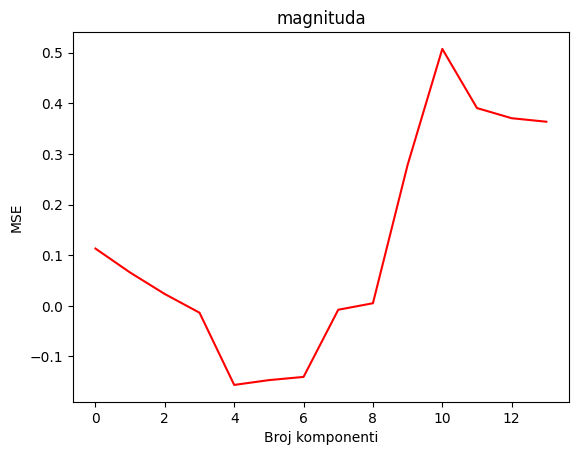

In [ ]:
pca = PCA()
x_reduced = pca.fit_transform(x_train)

#definisemo unakrsnu validaciju sa 10 podskupova
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
regr = SVR(kernel='poly', C=5)
mse = []

#Racunamo mse za jedan podskup
score = -1*model_selection.cross_val_score(regr, np.ones((len(x_reduced),1)), y_train, cv=cv, scoring='r2').mean()
mse.append(score)

#racunamo mse za svaki podskup
for i in np.arange(1, 14):
  score = -1*model_selection.cross_val_score(regr, x_reduced[:,:i], y_train, cv=cv, scoring='r2').mean()
  mse.append(score)

plt.plot(mse,color='red')
plt.xlabel('Broj komponenti')
plt.ylabel('MSE')
plt.title('magnituda')

#scale trening i test podataka
x_reduced_train = pca.fit_transform(x_train)
x_reduced_test = pca.transform(x_test)[:,:1]

#trening pca podataka na osnovu testa
regr.fit(x_reduced_train[:,:1], y_train)

#racunaje MSE
y_pred = regr.predict(x_reduced_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))